In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [2]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [3]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [4]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [5]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [6]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [7]:
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [9]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

<h1>LSTM1-CNN1</h1>

In [21]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_1 (Dropout)         (None, 128, 128)          0         
                                                                 
 conv1d (Conv1D)             (None, 126, 64)           24640     
                                                                 
 dropout_2 (Dropout)         (None, 126, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 63, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4032)              0         
                                                      

In [22]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 53s 883ms/step - loss: 0.7516 - accuracy: 0.6963 - val_loss: 0.4469 - val_accuracy: 0.8626
Epoch 2/10
58/58 [==============================] - 44s 765ms/step - loss: 0.2738 - accuracy: 0.8977 - val_loss: 0.2403 - val_accuracy: 0.9048
Epoch 3/10
58/58 [==============================] - 25s 440ms/step - loss: 0.1538 - accuracy: 0.9355 - val_loss: 0.1634 - val_accuracy: 0.9334
Epoch 4/10
58/58 [==============================] - 28s 484ms/step - loss: 0.1293 - accuracy: 0.9437 - val_loss: 0.1305 - val_accuracy: 0.9569
Epoch 5/10
58/58 [==============================] - 46s 802ms/step - loss: 0.1160 - accuracy: 0.9490 - val_loss: 0.1147 - val_accuracy: 0.9569
Epoch 6/10
58/58 [==============================] - 27s 468ms/step - loss: 0.1081 - accuracy: 0.9520 - val_loss: 0.1136 - val_accuracy: 0.9529
Epoch 7/10
58/58 [==============================] - 26s 444ms/step - loss: 0.1059 - accuracy: 0.9524 - val_loss: 0.1386 - val_accuracy: 0.9547

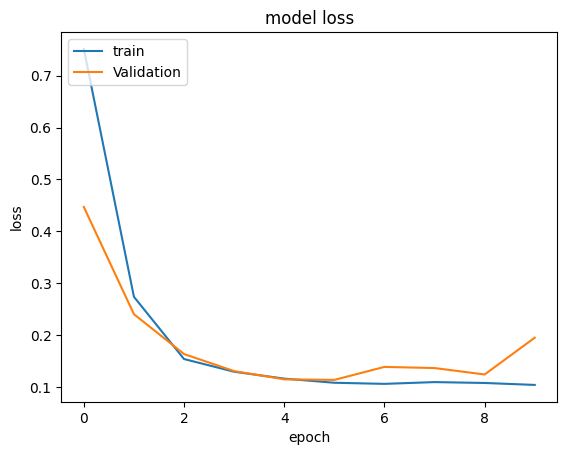

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

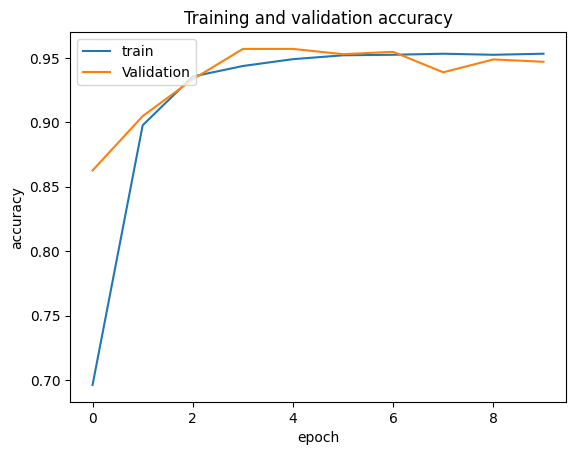

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 7s 67ms/step
[[468  10  16   0   2   0]
 [  3 448  20   0   0   0]
 [  0   5 415   0   0   0]
 [  0  24   0 337 102  28]
 [  1   0   0  47 484   0]
 [  0  27   0   0   0 510]]
0.9032914828639295
0.9011915282028541
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       496
           1       0.87      0.95      0.91       471
           2       0.92      0.99      0.95       420
           3       0.88      0.69      0.77       491
           4       0.82      0.91      0.86       532
           5       0.95      0.95      0.95       537

    accuracy                           0.90      2947
   macro avg       0.91      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



<Axes: >

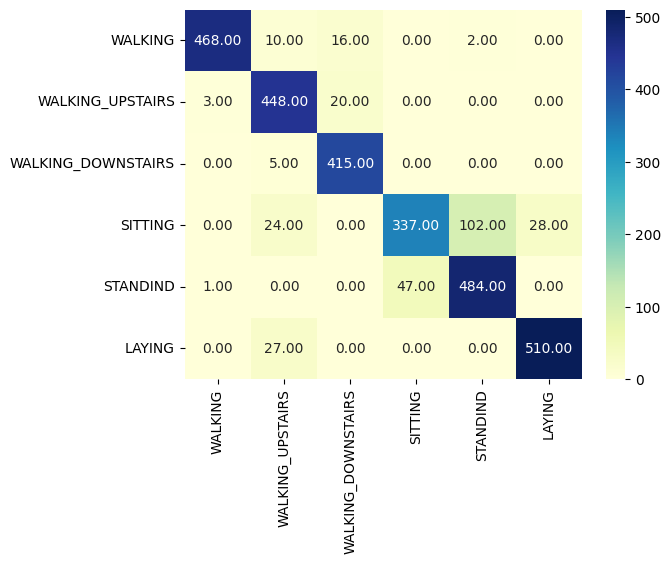

In [25]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>LSTM1-CNN 2</h1>

In [ ]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [26]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 27s 463ms/step - loss: 0.1401 - accuracy: 0.9457 - val_loss: 0.1352 - val_accuracy: 0.9560
Epoch 2/10
58/58 [==============================] - 27s 461ms/step - loss: 0.1100 - accuracy: 0.9532 - val_loss: 0.1134 - val_accuracy: 0.9606
Epoch 3/10
58/58 [==============================] - 27s 473ms/step - loss: 0.1042 - accuracy: 0.9533 - val_loss: 0.1010 - val_accuracy: 0.9633
Epoch 4/10
58/58 [==============================] - 25s 435ms/step - loss: 0.0954 - accuracy: 0.9580 - val_loss: 0.1113 - val_accuracy: 0.9510
Epoch 5/10
58/58 [==============================] - 24s 417ms/step - loss: 0.0963 - accuracy: 0.9581 - val_loss: 0.0980 - val_accuracy: 0.9674
Epoch 6/10
58/58 [==============================] - 25s 432ms/step - loss: 0.0951 - accuracy: 0.9588 - val_loss: 0.1097 - val_accuracy: 0.9646
Epoch 7/10
58/58 [==============================] - 27s 466ms/step - loss: 0.1102 - accuracy: 0.9544 - val_loss: 0.1035 - val_accuracy: 0.9669

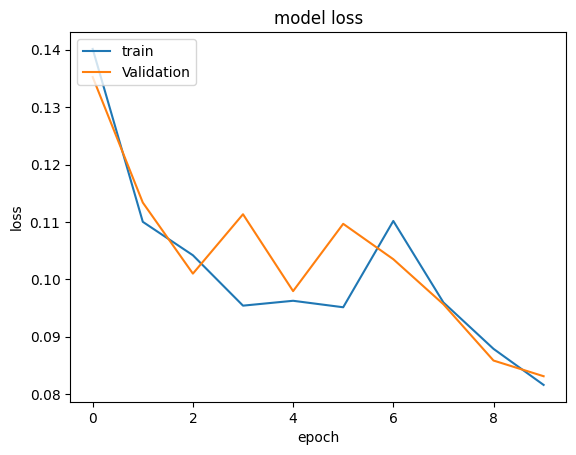

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

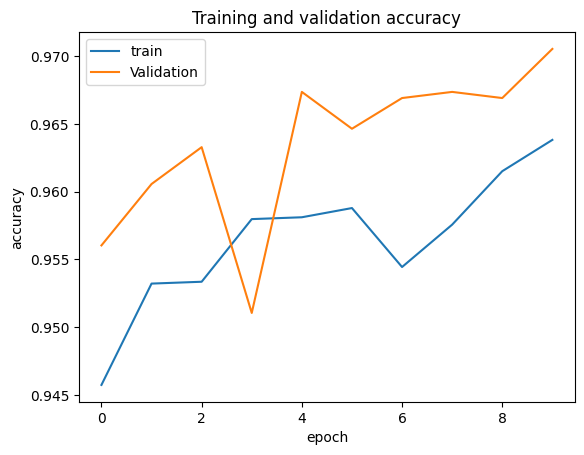

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 11s 116ms/step
[[469   3  24   0   0   0]
 [  2 440  29   0   0   0]
 [  0   1 419   0   0   0]
 [  0  19   0 366 100   6]
 [  1   1   0  42 488   0]
 [  0   0   0   0   0 537]]
0.9226331862911435
0.9215825426782629
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       496
           1       0.95      0.93      0.94       471
           2       0.89      1.00      0.94       420
           3       0.90      0.75      0.81       491
           4       0.83      0.92      0.87       532
           5       0.99      1.00      0.99       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



<Axes: >

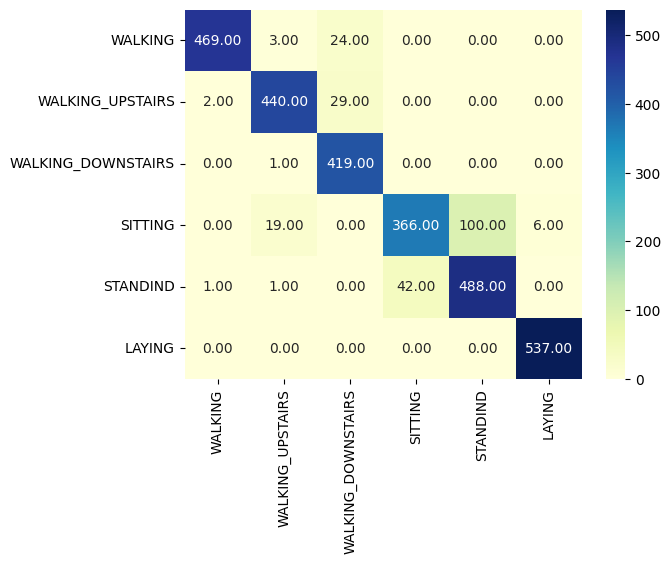

In [29]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>LSTM2-CNN1</h1>

In [30]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
# RNN layer
model.add(LSTM(units = 128, return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_3 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_4 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_4 (Dropout)         (None, 128, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 126, 64)           24640     
                                                                 
 dropout_5 (Dropout)         (None, 126, 64)           0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 63, 64)           

In [31]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 76s 1s/step - loss: 0.7908 - accuracy: 0.6760 - val_loss: 0.5074 - val_accuracy: 0.8246
Epoch 2/10
58/58 [==============================] - 54s 937ms/step - loss: 0.2834 - accuracy: 0.8930 - val_loss: 0.1931 - val_accuracy: 0.9266
Epoch 3/10
58/58 [==============================] - 69s 1s/step - loss: 0.1541 - accuracy: 0.9372 - val_loss: 0.1468 - val_accuracy: 0.9461
Epoch 4/10
58/58 [==============================] - 59s 1s/step - loss: 0.1344 - accuracy: 0.9427 - val_loss: 0.1276 - val_accuracy: 0.9547
Epoch 5/10
58/58 [==============================] - 54s 928ms/step - loss: 0.1205 - accuracy: 0.9494 - val_loss: 0.1314 - val_accuracy: 0.9411
Epoch 6/10
58/58 [==============================] - 55s 957ms/step - loss: 0.1209 - accuracy: 0.9495 - val_loss: 0.1353 - val_accuracy: 0.9533
Epoch 7/10
58/58 [==============================] - 54s 932ms/step - loss: 0.1240 - accuracy: 0.9472 - val_loss: 0.2187 - val_accuracy: 0.9234
Epoch 8/

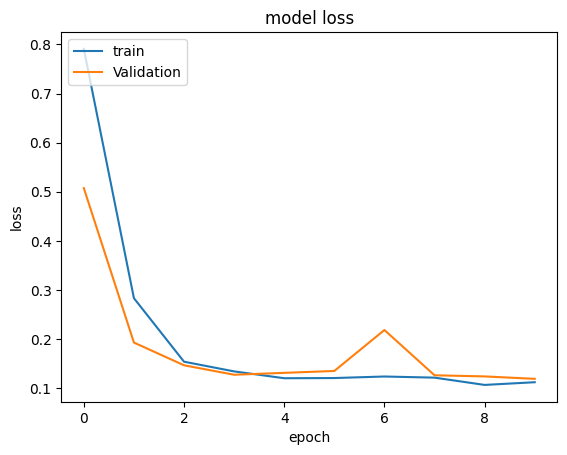

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

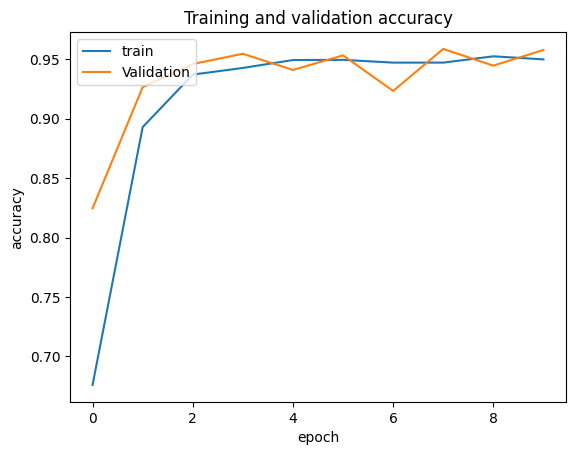

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 15s 149ms/step
[[463  20  13   0   0   0]
 [  0 466   5   0   0   0]
 [  0   9 411   0   0   0]
 [  0  18   0 375  92   6]
 [  2   2   0  53 475   0]
 [  0   0   0   0   0 537]]
0.9253478113335596
0.9244587818902563
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       496
           1       0.90      0.99      0.95       471
           2       0.96      0.98      0.97       420
           3       0.88      0.76      0.82       491
           4       0.84      0.89      0.86       532
           5       0.99      1.00      0.99       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.92      2947



<Axes: >

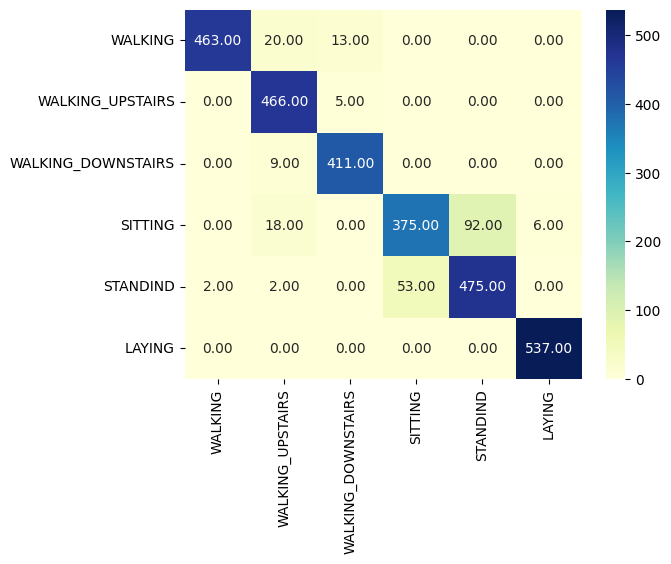

In [34]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>LSTM2-CNN2</h1>

In [35]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
# RNN layer
model.add(LSTM(units = 128, return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_6 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_6 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_7 (Dropout)         (None, 128, 128)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 126, 64)           24640     
                                                                 
 conv1d_3 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 dropout_8 (Dropout)         (None, 124, 64)          

In [36]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 68s 1s/step - loss: 0.8419 - accuracy: 0.6513 - val_loss: 0.5299 - val_accuracy: 0.7838
Epoch 2/10
58/58 [==============================] - 61s 1s/step - loss: 0.3041 - accuracy: 0.8851 - val_loss: 0.2004 - val_accuracy: 0.9184
Epoch 3/10
58/58 [==============================] - 57s 984ms/step - loss: 0.1623 - accuracy: 0.9338 - val_loss: 0.1518 - val_accuracy: 0.9456
Epoch 4/10
58/58 [==============================] - 56s 968ms/step - loss: 0.1300 - accuracy: 0.9457 - val_loss: 0.1281 - val_accuracy: 0.9456
Epoch 5/10
58/58 [==============================] - 62s 1s/step - loss: 0.1354 - accuracy: 0.9440 - val_loss: 0.2054 - val_accuracy: 0.9048
Epoch 6/10
58/58 [==============================] - 56s 974ms/step - loss: 0.1312 - accuracy: 0.9427 - val_loss: 0.1541 - val_accuracy: 0.9483
Epoch 7/10
58/58 [==============================] - 56s 975ms/step - loss: 0.1193 - accuracy: 0.9525 - val_loss: 0.1263 - val_accuracy: 0.9533
Epoch 8/

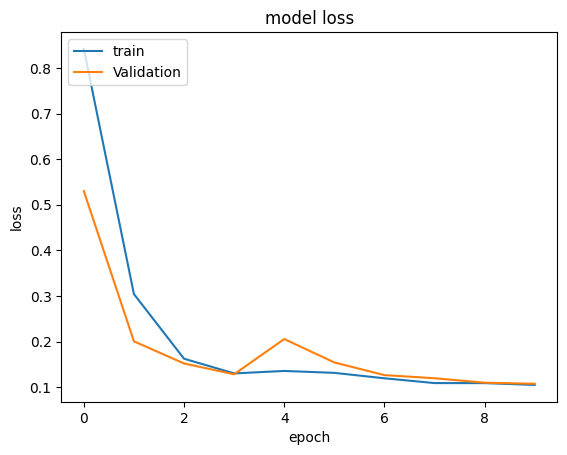

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

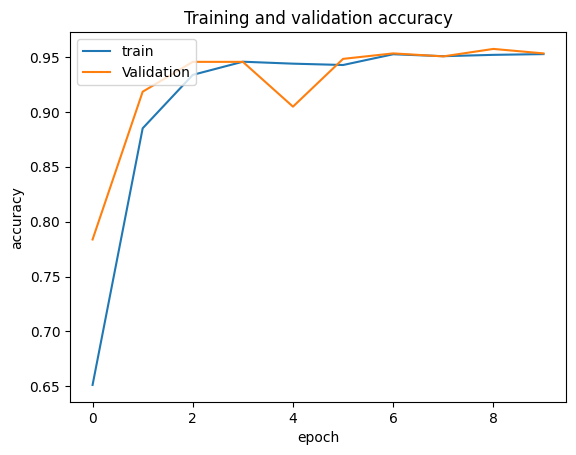

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 13s 136ms/step
[[470   6  20   0   0   0]
 [  9 441  21   0   0   0]
 [  1   0 419   0   0   0]
 [  0  21   0 374  92   4]
 [  2   2   0  68 460   0]
 [  0  25   0   0   0 512]]
0.9080420766881574
0.9073945695353478
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       496
           1       0.89      0.94      0.91       471
           2       0.91      1.00      0.95       420
           3       0.85      0.76      0.80       491
           4       0.83      0.86      0.85       532
           5       0.99      0.95      0.97       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

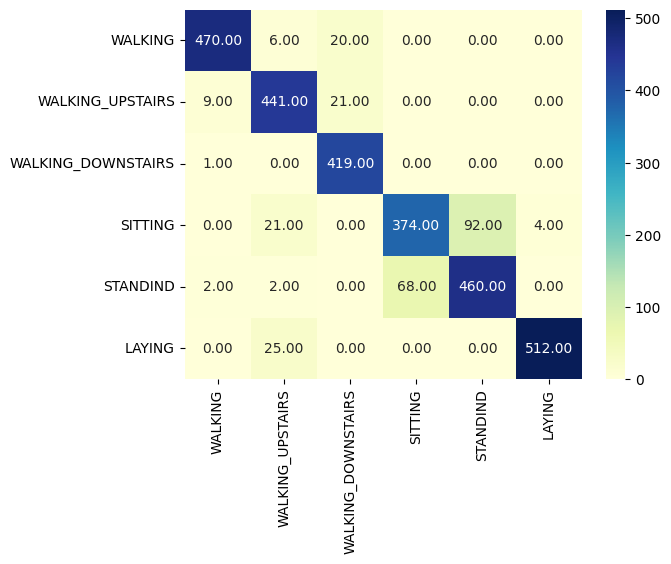

In [39]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')